In [1]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.stats import norm
from scipy.optimize import bisect

In [2]:
data = pd.read_csv('IV_Surface_US_Canada.csv')
data

,symbol,exchange,date,period,strike,out-of-the-money %,call/put,iv,delta
0,SPX,CBOE,03/30/17,30,2368.927,0,C,0.093276,0.492384
1,SPX,CBOE,03/30/17,30,2368.927,0,P,0.088111,-0.506990
2,SPX,CBOE,03/30/17,30,2487.373,5,C,0.087333,0.024455
3,SPX,CBOE,03/30/17,30,2250.481,5,P,0.139932,-0.100399
4,SPX,CBOE,03/30/17,30,2605.820,10,C,0.107517,0.000956
...,...,...,...,...,...,...,...,...,...
931,XIU,TSX,03/30/17,1080,11.530,50,P,0.206987,-0.020823
932,XIU,TSX,03/30/17,1080,35.743,55,C,0.149136,0.037532
933,XIU,TSX,03/30/17,1080,10.377,55,P,0.206987,-0.009907
934,XIU,TSX,03/30/17,1080,36.896,60,C,0.149136,0.028573


In [3]:
df = data[data.symbol == 'SPX']
print('symbol : ', df.symbol.iloc[0],
      '\nexchange : ', df.exchange.unique(),
      '\ndate : ', df.date.iloc[0])
df_put = df[df['call/put'] == 'P']
df = df[df['call/put'] == 'C']
df = df.drop(['symbol', 'exchange', 'date', 'call/put'], axis=1)
df

symbol :  SPX 
exchange :  ['CBOE'] 
date :  03/30/17


,period,strike,out-of-the-money %,iv,delta
0,30,2368.927,0,0.093276,0.492384
2,30,2487.373,5,0.087333,0.024455
4,30,2605.820,10,0.107517,0.000956
6,30,2724.266,15,0.107517,0.000003
8,30,2842.712,20,0.105356,0.000000
...,...,...,...,...,...
224,1080,3316.498,40,0.119641,0.056641
226,1080,3434.944,45,0.117873,0.037471
228,1080,3553.391,50,0.117873,0.025805
230,1080,3671.837,55,0.117873,0.017574


In [4]:
S0 = df.strike.iloc[0]

In [5]:
df_iv = df.pivot(index='period', columns='strike', values='iv')
df_iv.columns = df_iv.columns / S0
df_iv

strike,1.00,1.05,1.10,1.15,1.20,1.25,1.30,1.35,1.40,1.45,1.50,1.55,1.60
period,,,,,,,,,,,,,
30,0.093276,0.087333,0.107517,0.107517,0.105356,0.105356,0.105356,0.105356,0.105356,0.105356,0.105356,0.105356,0.105356
60,0.099009,0.082186,0.096382,0.097016,0.097016,0.097016,0.097016,0.097016,0.097016,0.097016,0.097016,0.097016,0.097016
90,0.108275,0.088502,0.092860,0.098367,0.098367,0.093031,0.093031,0.093031,0.093031,0.093031,0.093031,0.093031,0.093031
120,0.114047,0.092996,0.090601,0.097878,0.097878,0.097878,0.097878,0.097878,0.097878,0.097878,0.097878,0.097878,0.097878
150,0.117732,0.097354,0.090588,0.097264,0.103992,0.103992,0.103992,0.103992,0.103992,0.103992,0.103992,0.103992,0.103992
180,0.121048,0.101140,0.091680,0.093067,0.093281,0.093281,0.093281,0.093281,0.093281,0.093281,0.093281,0.093281,0.093281
360,0.134686,0.119285,0.106209,0.098021,0.095133,0.094942,0.094942,0.094942,0.094942,0.094942,0.094942,0.094942,0.094942
720,0.156742,0.146801,0.137436,0.128802,0.121654,0.115976,0.114029,0.112982,0.112332,0.111698,0.111698,0.111698,0.111698
1080,0.165562,0.157533,0.149942,0.142056,0.135194,0.129532,0.124838,0.121439,0.119641,0.117873,0.117873,0.117873,0.117873


<IPython.core.display.Javascript object>


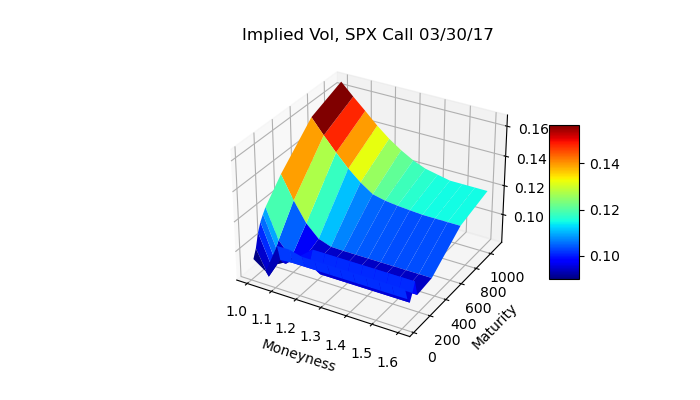

Text(0.5, 0.92, 'Implied Vol, SPX Call 03/30/17')

In [6]:
X, Y = df_iv.columns.values, df_iv.index.values
X, Y = np.meshgrid(X, Y)
Z = df_iv.values
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111, projection='3d')

mycmap = plt.get_cmap('jet')
surf = ax.plot_surface(X, Y, Z, cmap=mycmap)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel('Moneyness')
ax.set_ylabel('Maturity')
ax.set_zlabel('Implied Vol')
plt.title('Implied Vol, SPX Call 03/30/17')

In [7]:
def BS_original(s, k, r, sigma, T):
    d1 = (np.log(s/k) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    C = s * norm.cdf(d1) - k * np.exp(-r * T) * norm.cdf(d2)
    return C

In [8]:
rate = 0.025

prices = []
mat_norm = [m / 360 for m in df_iv.index]
for m in range(len(df_iv.index)):
    line = []
    for k in range(len(df_iv.columns)):
        price = BS_original(S0, df_iv.columns[k]*S0, rate, df_iv[df_iv.columns[k]].iloc[m], mat_norm[m])
        line.append(price)
    prices.append(line)
prices = np.array(prices)

<IPython.core.display.Javascript object>


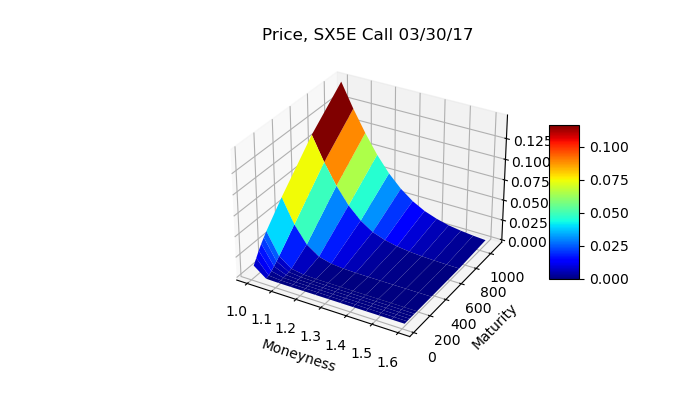

Text(0.5, 0.92, 'Price, SX5E Call 03/30/17')

In [9]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111, projection='3d')

mycmap = plt.get_cmap('jet')
surf = ax.plot_surface(X, Y, prices/S0, cmap=mycmap)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel('Moneyness')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price / Spot')
plt.title('Price, SX5E Call 03/30/17')

In [10]:
df_prices = pd.DataFrame(prices, index=df_iv.index, columns=df_iv.columns)
df_prices_final = df_prices[df_prices.columns[:6]].loc[:180]

<IPython.core.display.Javascript object>


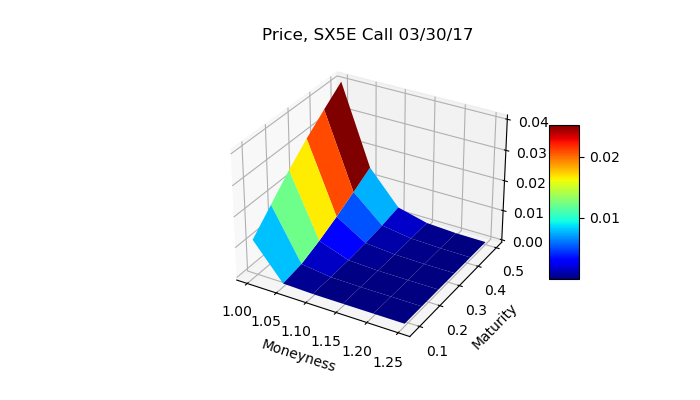

Text(0.5, 0.92, 'Price, SX5E Call 03/30/17')

In [11]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111, projection='3d')
X, Y = df_prices_final.columns.values, df_prices_final.index.values / 360
X, Y = np.meshgrid(X, Y)

mycmap = plt.get_cmap('jet')
surf = ax.plot_surface(X, Y, df_prices_final.values/S0, cmap=mycmap)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel('Moneyness')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price / Spot')
plt.title('Price, SX5E Call 03/30/17')

In [13]:
# (df_prices_final/S0).to_csv('target_SPX_price.csv')